In [1]:
# import the necessary packages
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io, color, feature
import matplotlib.pyplot as plt
import numpy as np
import cv2  # Add this import for OpenCV

# load the image and convert it to a floating point data type
image = img_as_float(io.imread("40.jpg"))

# apply SLIC and extract (approximately) the supplied number of segments
segments = slic(image, n_segments=1000, sigma=5)

# find the central segment (you can customize this based on your needs)
center_y, center_x = image.shape[:2]
center_segment = segments[center_y // 2, center_x // 2]

# create a mask for the central segment
center_mask = (segments == center_segment)

# apply Canny edge detector to the central segment
gray_image = color.rgb2gray(image)
edges = feature.canny(gray_image)

# combine the edges with the central segment mask
edges_in_center = np.logical_and(edges, center_mask)

# intensity thresholding to classify segments into cancerous and non-cancerous
threshold = 0.49  # you may need to adjust this threshold based on your data
cancer_mask = gray_image > threshold

# Save resulted images using cv2
cv2.imwrite("superpixels_with_central_segment.png", (mark_boundaries(image, segments) * 255).astype(np.uint8))
cv2.imwrite("canny_edges_in_central_segment.png", (edges_in_center * 255).astype(np.uint8))
cv2.imwrite("cancerous_areas.png", (cancer_mask * 255).astype(np.uint8))


True

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pyswarm import pso

# Load the image
image_path = "superpixels_with_central_segment.png"  # Change this to your image path
original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Define the fitness function for PSO
def fitness_function(params):
    # Convert parameters to integers
    params = params.astype(int)

    # Apply Canny edge detection
    edges = cv2.Canny(original_image, params[0], params[1])

    # Calculate the fitness (minimize the sum of edge pixels)
    fitness = np.sum(edges)

    # Save the image at this stage
    #cv2.imwrite(f'edge_detection_{params[0]}_{params[1]}.png', edges)

    return fitness

# Define the parameter bounds for PSO
lb = [0, 0]  # Lower bounds for the parameters
ub = [255, 255]  # Upper bounds for the parameters

# Run PSO to optimize parameters
best_params, _ = pso(fitness_function, lb, ub, swarmsize=10, maxiter=10)

# Apply the best parameters to Canny edge detection
best_params = best_params.astype(int)
optimized_edges = cv2.Canny(original_image, best_params[0], best_params[1])

# Save the final result
cv2.imwrite('optimized_edge_detection.png', optimized_edges)


Stopping search: maximum iterations reached --> 10


True

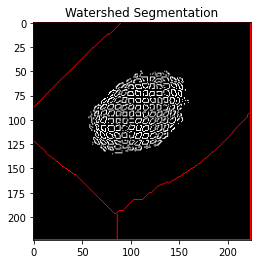

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = "optimized_edge_detection.png"  # Change this to your image path
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply thresholding to create a binary image
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Noise removal using morphological operations
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Sure background area
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labelling
_, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers + 1

# Mark the region of unknown with zero
markers[unknown == 255] = 0

# Apply watershed algorithm
cv2.watershed(image, markers)

# Outline the segmented regions
image[markers == -1] = [0, 0, 255]  # Mark watershed boundaries with red color

# Display the result
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Watershed Segmentation')
plt.show()


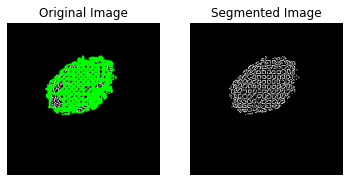

In [9]:
import cv2
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread('optimized_edge_detection.png')

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply thresholding to create a binary image
_, binary_image = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

# Find contours in the binary image
contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Iterate through each contour
for contour in contours:
    # Apply Convex Hull to each contour
    hull = cv2.convexHull(contour)

    # Draw the Convex Hull on the original image
    cv2.drawContours(image, [hull], 0, (0, 255, 0), 2)

# Save the original and segmented images separately
cv2.imwrite('original_image.jpg', cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
cv2.imwrite('segmented_image.jpg', binary_image)

# Display the original and segmented images using Matplotlib
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Segmented Image')
plt.imshow(binary_image, cmap='gray')
plt.axis('off')

plt.show()


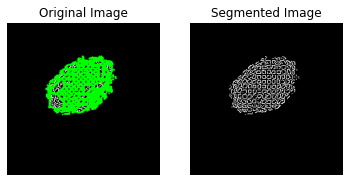

In [10]:
import cv2
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread('segmented_image.jpg')

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply thresholding to create a binary image
_, binary_image = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

# Find contours in the binary image
contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Iterate through each contour
for contour in contours:
    # Apply Convex Hull to each contour
    hull = cv2.convexHull(contour)

    # Draw the Convex Hull on the original image
    cv2.drawContours(image, [hull], 0, (0, 255, 0), 2)

# Save the segmented image
cv2.imwrite('final_segmented_image.jpg', image)

# Display the original and segmented images using Matplotlib
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Segmented Image')
plt.imshow(binary_image, cmap='gray')
plt.axis('off')

plt.show()
